/Users/sebastianopian/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Risultati delle misurazioni (con rumore): [tensor(-0.61105255, requires_grad=True), tensor(-0.58198713, requires_grad=True)]


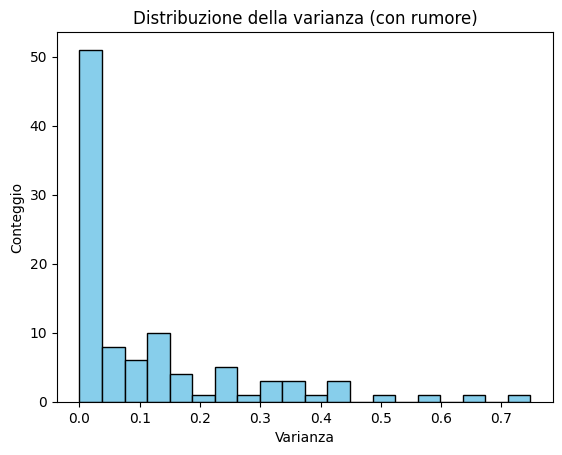

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# Numero di qubit e device con rumore
n_qubits = 2
dev = qml.device("default.mixed", wires=n_qubits)

# Definizione del rumore (esempio: depolarizzante)
def noisy_operation():
    qml.DepolarizingChannel(0.1, wires=0)  # Rumore depolarizzante sul primo qubit
    qml.DepolarizingChannel(0.1, wires=1)  # Rumore depolarizzante sul secondo qubit

# Circuito parametrico (PQC)
def ansatz(params):
    for i in range(n_qubits):
        qml.RX(params[i], wires=i)
    for i in range(n_qubits - 1):
        qml.CNOT(wires=[i, i + 1])
    noisy_operation()  # Aggiungi il rumore

# Definizione della funzione osservabile
@qml.qnode(dev)
def circuit(params):
    ansatz(params)
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Generazione di dati casuali per i parametri
np.random.seed(42)
params = np.random.uniform(0, 2 * np.pi, n_qubits)

# Misurazioni con rumore
results = circuit(params)
print(f"Risultati delle misurazioni (con rumore): {results}")

# Analisi della varianza
variances = []
num_samples = 100
for _ in range(num_samples):
    params = np.random.uniform(0, 2 * np.pi, n_qubits)
    results = circuit(params)
    variances.append(np.var(results))

# Grafico della varianza
plt.hist(variances, bins=20, color="skyblue", edgecolor="black")
plt.title("Distribuzione della varianza (con rumore)")
plt.xlabel("Varianza")
plt.ylabel("Conteggio")
plt.show()